# 5章　リカレントニューラルネットワーク(RNN)

In [1]:
#必要なライブラリのimport
import numpy as np
import matplotlib.pyplot as plt

いままで扱ってきたニューラルネットワークはフィードフォワードというタイプのネットワークでした。  
  
フィードフォワードのネットワークは一方向だけの流れしか持っていません  
  
そのため時系列データをうまく扱うことができません。  
  
その改善策としてリカレントニューラルネットワーク(以下RNN)をここで提案していきます。  
  
そして最終的にはRNNを使って言語モデルを実装します
  
それではまず「言語モデル」とはなにか、そのためのRNNとは何なのかじっくり見ていきましょう！

## 言語モデルとは
言語モデル(Language Model)は単語の並びに対して確率を与え単語の並びがどれだけ自然かを評価することができます。  
  
言語モデルの使用方法としては
1. 単語の予測
1. 文章生成  
が主としてあります。  

## CBOWモデルの問題点とRNN


CBOWモデルの中間層では単語ベクトルの和を求めていました。  
  
和を求めるとコンテキストの並び順は無視されてしまいます。  
  
言語モデルではこの順序がとても重要です
  
下の画像の右の図は和ではなく連結することを考えてみました。  
  
しかし、これだとコンテキストのサイズを増やすほどパラメータが増えるためあまり好ましくありません。  

![alt text](../pictures/pict20.png)

そこで解決策としてリカレントニューラルネットワーク(*RNN*)を提案します。

リカレントニューラルネットワークとは循環するネットワーク構造を持つニューラルネットワークのことをいいます。  
  
RNNの最大の特徴はこのループ構造のおかげで過去の情報を記憶しながら更新を進めていくことができるということです。  
  
![alt text](../pictures/pict21.png)  
  
上の図のx_tは入力された時系列データでh_tは出力の値を示しています。  
  
しかし、これではまだ構造が見えてこないのでこのループを展開してみましょう  
  
![alt text](../pictures/pict22.png)  
  
実はループ構造の正体は同一のレイヤを繋げたフィードフォワード型のニューラルネットワークだったのです。  
  
それではこの細かいレイヤの計算処理を見ていきましょう  
  
計算式は以下のようになっています。  
  
$$
h_{t} = \text{tanh}(h_{t-1}W_{h} + x_{t}W_{x} + b)
$$

h_(t-1)は前層の出力であり、これこそがRNNの特徴でもあります。  
  
また、式を見たら分かる通り重みは二種類あり、バイアスもあります。  
  
順伝播についてはこれくらいにして逆伝播にいきましょう  

### 逆伝播

ニューラルネットワークであれば逆伝播ももちろん存在します。  
  
![alt text](../pictures/pict23.png)  
  
これはBackpropagation Through Time(BPTT)と呼ばれます。  
  
さてこれをもとに実装したいのですが問題があります。  
  
それは長い時系列データを扱う際に起きる計算リソースの増加と勾配消失の問題です  
  
これを対処するために長いネットワークを途中で切ることをします。  
  
![alt text](../pictures/pict24.png)  
  
ただ、注意してほしいのは切るのは「逆伝播」だけであることです。  
  
この処理はミニバッチ処理と似ていますが、ランダムにデータを選べないという点で決定的に異なります。  
  
この分割する方法Truncated BPTTといいます。

実際に駆動するときは以下のように伝播していきます
![alt text](../pictures/pict25.png)
![alt text](../pictures/pict26.png)

### ミニバッチ学習
それでは最後にバッチ処理について見ていきましょう  
  
Truncated BPTTのミニバッチ学習ではランダムにデータを撮ってくることができません  
  
今回はデータを”ズラす”方法を取ります。  
  
例として長さ1000の時系列データを考えてみましょう。  
  
バッチ数が2なら、ぞれぞれのブロックの開始位置を500だけズラしてあげるだけでいいです。  
  
![alt text](../pictures/pict28.png)
  
このようにTruncated BPTTは原理自体はそこまで難しくはないですが、  
  
今までとは異なるデータの与え方をしないといけないので注意が必要です。  

## RNNの実装

さて、注意する点もわかったところでRNNを実装していきましょう  
  
今回の実装では展開する前のループ構造を"Time RNN"レイヤとして、ループ中の細かい構造を"RNN"レイヤとして実装します。  
  
まずはRNNレイヤの実装です

### RNNレイヤの実装
RNNレイヤの順伝播、逆伝播を計算グラフで見てみましょう
![alt text](../pictures/pict29.png) 
![alt text](../pictures/pict30.png)  
  
計算に使われているのは"MatMul"と"＋"と"tanh"です。  
  
tanh以外は今までに実装済みなのでtanhの逆伝播だけ考えてみましょう  
  
tanhの定義は
$$
f(x) = \text{tanh}(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$
これを微分すると
$$
f'(x) = 1 - {f(x)}^{2}
$$

In [2]:
#RNNレイヤの実装
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

        #Wx:入力xにかかる重み, Wh:前の時刻の隠れ状態hにかかる重み, b:バイアス

    def forward(self, x, h_prev): #h_prev:前の時刻の隠れ状態
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next) #逆伝播のために保持
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2) #tanhの微分
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

### Time RNNレイヤの実装

Time RNNレイヤはT個のRNNレイヤから構成されます。  
  
今回の実装ではRNNレイヤのhの保持をTime RNNレイヤに任せることにしまあ￥す。  
  
この機能はstatefulという引数で任意に選べるようにします  
  
やや複雑ですが逆伝播も見ていきましょう  
![alt text](../pictures/pict31.png)
  
より細かく見てみると
![alt text](../pictures/pict32.png)

t番目のRNNレイヤには上からの勾配(dh_t)と一つ未来からの勾配(dh_next)を合算した値を入力として扱います。  


In [3]:
#Time RNNレイヤの実装
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        #N:バッチサイズ, T:時系列データの長さ, D:入力データの次元, H:隠れ状態の次元

        self.layers = []
        hs = np.empty((N, T, H), dtype='f') #出力の初期化

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h #hsに出力を格納
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f') #勾配の初期化
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx #dxsに勾配を格納

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None



np.emptyはnp.zerosやnp.onesよりも処理速度が早いため値の初期化をしなくていい場合はnp.emptyのほうが優れている

## 言語モデルとRNN

RNNは無事実装できましたが、まだ言語モデルを実装するには準備が足りません。  
  
まずは図を使って理解していくことにしましょう。

![alt text](../pictures/pict33.png)

RNNを使った言語モデル(RNNLM)は上の図のようにw_tを与えると確率としてy_tが得られます。  
  
途中通るレイヤを見ると今まで実装してきたレイヤばかりであまり難しそうには見えませんね。  
  
ただ、RNNレイヤは時系列データをまとめて処理することのできるTime RNNレイヤを持っていますが  
  
他のレイヤ(EmbeddingやAffineレイヤなど)はそういったレイヤを持っていません  
  
そこでこれらもまとめてTime 〇〇レイヤとして実装しようと思います。

![alt text](../pictures/pict34.png)

In [4]:
#Time Embeddingレイヤの実装
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

In [5]:
#Time Affineレイヤの実装
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

Time Softmax with Lossレイヤは少し特殊です。  
  
![alt text](../pictures/pict35.png)  
  
xは下から伝わってくるスコア、tはそれぞれの正解ラベルです。  
  
図のLはそれぞれからの損失を平均した値です。  

In [6]:
#Time Softmax with Lossレイヤの実装
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 教師ラベルがone-hotベクトルの場合
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # バッチ分と時系列分をまとめる（reshape）
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_labelに該当するデータは損失を0にする
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelに該当するデータは勾配を0にする

        dx = dx.reshape((N, T, V))

        return dx

準備も整ったところでRNNLMの実装をしていきましょう。

In [7]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

### 言語モデルの評価

RNNLMの実装も終わったのであとはデータを与えて学習するだけですが、その前にモデルの評価についても学んでおきましょう。  
  
今回は評価指標として「perplexity」を用います
perplexityの定義
$$
\text{PP}(W) = \text{e}^{-\frac{1}{N}\sum_{n} \sum_{k} t_{n,k}\text{log}y_{n,k}}
$$

指数の肩に乗っている式は簡単に言うと"正解の単語の確率"のlogです。  
  
この式だけだと少し意味がわからないので１単語で考えてみます。  
  
このとき
$$
\text{PP}(W) = \text{e}^{-log(正解の単語の予測確率)}
$$
これは正しい予測確率の逆数になります。  
  
例えば予測確率が0.5ならperplexityは2になります。  
  
この数は**選択肢**と捉えることができ、小さければ小さいほどいい予測ができているということを表しています。

評価指標もわかったところでRNNLMの学習をしていきましょう。

corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 405.53
| epoch 2 | perplexity 308.88
| epoch 3 | perplexity 236.41
| epoch 4 | perplexity 219.87
| epoch 5 | perplexity 209.02
| epoch 6 | perplexity 203.84
| epoch 7 | perplexity 199.96
| epoch 8 | perplexity 196.88
| epoch 9 | perplexity 191.54
| epoch 10 | perplexity 192.26
| epoch 11 | perplexity 188.11
| epoch 12 | perplexity 191.37
| epoch 13 | perplexity 188.28
| epoch 14 | perplexity 188.04
| epoch 15 | perplexity 186.63
| epoch 16 | perplexity 183.42
| epoch 17 | perplexity 182.04
| epoch 18 | perplexity 178.87
| epoch 19 | perplexity 181.00
| epoch 20 | perplexity 179.71
| epoch 21 | perplexity 177.57
| epoch 22 | perplexity 173.34
| epoch 23 | perplexity 170.11
| epoch 24 | perplexity 172.35
| epoch 25 | perplexity 168.69
| epoch 26 | perplexity 165.53
| epoch 27 | perplexity 162.13
| epoch 28 | perplexity 159.65
| epoch 29 | perplexity 158.49
| epoch 30 | perplexity 149.65
| epoch 31 | perplexity 150.73
| epoch 

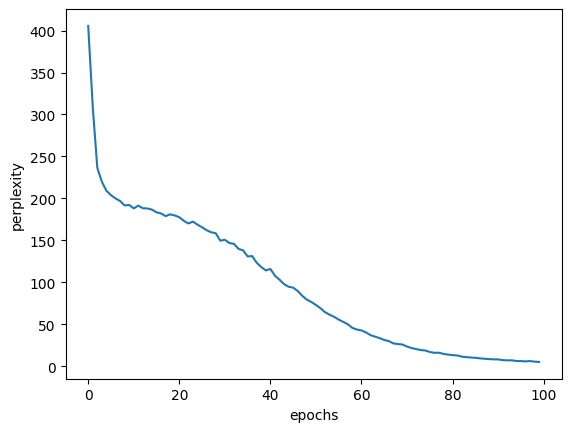

In [8]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from datasets import ptb
from simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

このようにperplexityが1に近づいていっているのが分かります。  
  
ただ、今回実装したSimpleRnnlmもコーパスサイズの増加による問題が解決しきれていません。   
  
次章ではその問題点にフォーカスしていきます。

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 419.09
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 405.79
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 311.14
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 233.41
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 216.54
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 212.88
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 203.74
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 201.26
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 196.90
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 191.64
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 192.48
| epoch 12 |  iter 1 / 19 | time 0[s] | perplexity 189.25
| epoch 13 |  iter 1 / 19 | time 0[s] | perplexity 192.62
| epoch 14 |  iter 1 / 19 | time 0[s] | perplexity 187.84
| epoch 15 |  iter 1 / 19 | time 0[s] | perplexity 186.75
| epoch 16 |  iter 1 / 19 | time 0[s] | perplexity 189.88
| epoch 17 |  iter 1 / 19 | time 0[s] | perplexity 188.35
| epoch 18 |  iter 1 / 

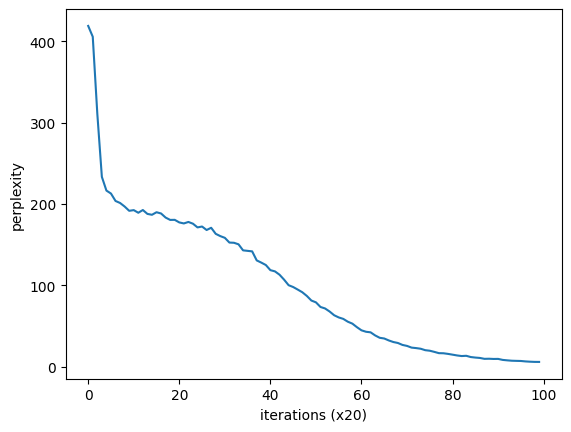

In [9]:
#RNNLMTrainerを使った学習
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from datasets import ptb
from simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 5  # RNNを展開するサイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # テスト用にデータセットを小さくする
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()